# 尼罗罗非鱼 (Oreochromis niloticus) 贝叶斯占有模型分析

本笔记本使用 Biolith 包对尼罗罗非鱼的出现数据进行贝叶斯占有模型分析。

## 数据来源
- GBIF (全球生物多样性信息设施)
- FishNet2
- iDigBio


In [1]:
# 导入基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 导入专业地理可视化库
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import cartopy.io.img_tiles as cimgt
    CARTOPY_AVAILABLE = True
    print("✓ Cartopy 可用 - 将使用专业地图绘制")
except ImportError:
    CARTOPY_AVAILABLE = False
    print("✗ Cartopy 未安装，请安装: pip install cartopy geopandas shapely")
    print("  当前将使用基础matplotlib绘图")

# 尝试导入GeoPandas用于更高级的地理数据处理
try:
    import geopandas as gpd
    from shapely.geometry import Point
    GEOPANDAS_AVAILABLE = True
    print("✓ GeoPandas 可用")
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("✗ GeoPandas 未安装")

# 设置Nature期刊级别的绘图参数
# 参考Nature期刊的图表规范
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 7  # Nature推荐字体大小
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.size'] = 2.5
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['legend.frameon'] = False
plt.rcParams['figure.dpi'] = 150  # 屏幕显示
plt.rcParams['savefig.dpi'] = 1200  # 保存为1200 dpi
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['pdf.fonttype'] = 42  # TrueType字体，确保可编辑
plt.rcParams['ps.fonttype'] = 42

# Nature期刊配色方案
# 使用色觉友好的配色
NATURE_COLORS = {
    'primary': '#0173B2',    # 蓝色
    'secondary': '#DE8F05',  # 橙色
    'tertiary': '#029E73',   # 绿色
    'red': '#CC3311',        # 红色
    'purple': '#755BB1',     # 紫色
    'brown': '#9A6324',      # 棕色
    'land': '#F5F5F5',       # 陆地浅灰色
    'ocean': '#E3F2FD',      # 海洋浅蓝色
    'border': '#CCCCCC',     # 边界灰色
}

print("✓ 基础库导入成功")
print(f"✓ Nature期刊绘图参数已配置 (输出分辨率: 1200 dpi)")


✓ Cartopy 可用 - 将使用专业地图绘制
✓ GeoPandas 可用
✓ 基础库导入成功
✓ Nature期刊绘图参数已配置 (输出分辨率: 1200 dpi)


## 1. 数据加载和清理


In [2]:
# 加载 GBIF 数据
gbif_data = pd.read_csv('data/Oreochromis niloticus OCC/gbif_occurrence.csv')
print(f"GBIF 数据: {len(gbif_data)} 条记录")
print(f"列: {list(gbif_data.columns)}\n")

# 加载 FishNet2 数据
fishnet_data = pd.read_csv('data/Oreochromis niloticus OCC/fishnet2_occurrence.csv')
print(f"FishNet2 数据: {len(fishnet_data)} 条记录")
print(f"列: {list(fishnet_data.columns)}\n")

# 加载 iDigBio 数据
idigbio_data = pd.read_csv('data/Oreochromis niloticus OCC/idigbio_occurrence.csv')
print(f"iDigBio 数据: {len(idigbio_data)} 条记录")
print(f"列: {list(idigbio_data.columns)}")


GBIF 数据: 88546 条记录
列: ['gbifID', 'occurrenceStatus', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species', 'acceptedScientificName', 'verbatimScientificName']

FishNet2 数据: 819 条记录
列: ['ScientificName', 'Latitude', 'Longitude', 'YearCollected', 'MonthCollected', 'DayCollected']

iDigBio 数据: 639 条记录
列: ['dwc:basisOfRecord', 'idigbio:eventDate', 'idigbio:dataQualityScore', 'idigbio:flags', 'idigbio:geoPoint', 'dwc:scientificName']


In [3]:
# 清理和标准化 GBIF 数据
gbif_clean = gbif_data.copy()
gbif_clean['latitude'] = pd.to_numeric(gbif_clean['decimalLatitude'], errors='coerce')
gbif_clean['longitude'] = pd.to_numeric(gbif_clean['decimalLongitude'], errors='coerce')
gbif_clean['date'] = pd.to_datetime(gbif_clean['eventDate'], errors='coerce')
gbif_clean['year'] = gbif_clean['date'].dt.year
gbif_clean['source'] = 'GBIF'
gbif_clean = gbif_clean[['latitude', 'longitude', 'year', 'date', 'source']].dropna(subset=['latitude', 'longitude'])

print(f"清理后的 GBIF 数据: {len(gbif_clean)} 条记录")
print(f"年份范围: {gbif_clean['year'].min():.0f} - {gbif_clean['year'].max():.0f}")


清理后的 GBIF 数据: 88546 条记录
年份范围: 1958 - 2025


In [4]:
# 清理和标准化 FishNet2 数据
fishnet_clean = fishnet_data.copy()
# 转换为数值类型（FishNet2的坐标是字符串）
fishnet_clean['latitude'] = pd.to_numeric(fishnet_clean['Latitude'], errors='coerce')
fishnet_clean['longitude'] = pd.to_numeric(fishnet_clean['Longitude'], errors='coerce')
fishnet_clean['year'] = pd.to_numeric(fishnet_clean['YearCollected'], errors='coerce')
fishnet_clean['source'] = 'FishNet2'
fishnet_clean = fishnet_clean[['latitude', 'longitude', 'year', 'source']].dropna(subset=['latitude', 'longitude'])

print(f"清理后的 FishNet2 数据: {len(fishnet_clean)} 条记录")
if len(fishnet_clean) > 0 and fishnet_clean['year'].notna().any():
    print(f"年份范围: {fishnet_clean['year'].min():.0f} - {fishnet_clean['year'].max():.0f}")


清理后的 FishNet2 数据: 387 条记录
年份范围: 0 - 2023


In [5]:
# 清理和标准化 iDigBio 数据
import json
idigbio_clean = idigbio_data.copy()

# 解析 geoPoint JSON 字段
def parse_geopoint(geopoint_str):
    try:
        geo = json.loads(geopoint_str.replace("'", '"'))
        return geo.get('lat'), geo.get('lon')
    except:
        return None, None

idigbio_clean['latitude'], idigbio_clean['longitude'] = zip(*idigbio_clean['idigbio:geoPoint'].apply(parse_geopoint))

# 确保坐标是数值类型
idigbio_clean['latitude'] = pd.to_numeric(idigbio_clean['latitude'], errors='coerce')
idigbio_clean['longitude'] = pd.to_numeric(idigbio_clean['longitude'], errors='coerce')

# 解析日期（使用 utc=True 处理带时区的日期）
idigbio_clean['date'] = pd.to_datetime(idigbio_clean['idigbio:eventDate'], errors='coerce', utc=True)

# 提取年份
if idigbio_clean['date'].notna().any():
    idigbio_clean['year'] = idigbio_clean['date'].dt.year
else:
    idigbio_clean['year'] = None

idigbio_clean['source'] = 'iDigBio'
idigbio_clean = idigbio_clean[['latitude', 'longitude', 'year', 'date', 'source']].dropna(subset=['latitude', 'longitude'])

print(f"清理后的 iDigBio 数据: {len(idigbio_clean)} 条记录")
if len(idigbio_clean) > 0 and idigbio_clean['year'].notna().any():
    print(f"年份范围: {idigbio_clean['year'].min():.0f} - {idigbio_clean['year'].max():.0f}")


清理后的 iDigBio 数据: 639 条记录
年份范围: 1913 - 2024


In [6]:
# 合并所有数据
all_data = pd.concat([gbif_clean, fishnet_clean, idigbio_clean], ignore_index=True)
all_data = all_data.dropna(subset=['latitude', 'longitude'])

print(f"\n合并后的总数据: {len(all_data)} 条记录")
print(f"\n数据源分布:")
print(all_data['source'].value_counts())
print(f"\n地理范围:")
print(f"  Latitude (°N): {all_data['latitude'].min():.2f}° 到 {all_data['latitude'].max():.2f}°")
print(f"  Longitude (°E): {all_data['longitude'].min():.2f}° 到 {all_data['longitude'].max():.2f}°")



合并后的总数据: 89572 条记录

数据源分布:
source
GBIF        88546
iDigBio       639
FishNet2      387
Name: count, dtype: int64

地理范围:
  Latitude (°N): -34.05° 到 67.24°
  Longitude (°E): -155.99° 到 178.45°


## 2. 探索性数据分析


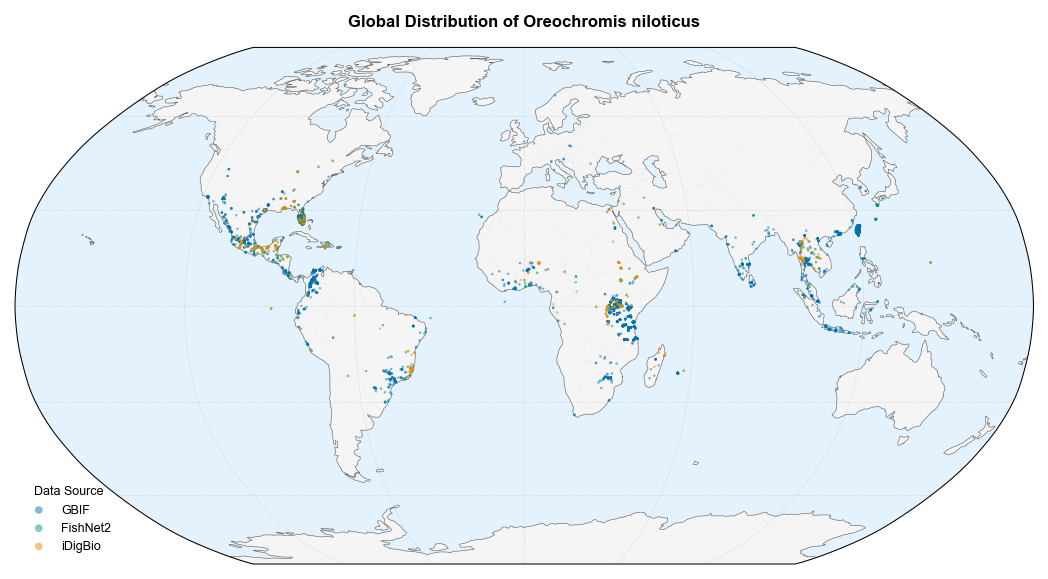

✓ 全球分布散点图已保存:
  - distribution_scatter_map.pdf (矢量格式, 1200 dpi)
  - distribution_scatter_map.png (栅格格式, 1200 dpi)


In [7]:
## 图1: 全球分布散点图 (Global Distribution Scatter Map)
# 使用Cartopy绘制专业的地理分布图

if CARTOPY_AVAILABLE:
    # 创建图形 - Nature期刊单栏图尺寸 (89mm = 3.5 inches)
    fig = plt.figure(figsize=(7, 4.5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())  # 使用Robinson投影
    
    # 设置地图范围
    ax.set_global()
    
    # 添加地理要素 - Nature风格
    ax.add_feature(cfeature.LAND, facecolor=NATURE_COLORS['land'], zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor=NATURE_COLORS['ocean'], zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3, edgecolor='#666666', zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor=NATURE_COLORS['border'], 
                   linestyle=':', alpha=0.6, zorder=1)
    
    # 按数据源绘制不同颜色的点
    source_colors = {
        'GBIF': NATURE_COLORS['primary'],      # 蓝色
        'iDigBio': NATURE_COLORS['secondary'],  # 橙色
        'FishNet2': NATURE_COLORS['tertiary']   # 绿色
    }
    
    for source in all_data['source'].unique():
        subset = all_data[all_data['source'] == source]
        ax.scatter(subset['longitude'], subset['latitude'], 
                  c=source_colors.get(source, NATURE_COLORS['primary']),
                  s=1.5, alpha=0.5, label=source,
                  transform=ccrs.PlateCarree(), 
                  edgecolors='none', zorder=2)
    
    # 添加图例
    legend = ax.legend(loc='lower left', fontsize=6, 
                      markerscale=3, framealpha=0.9,
                      title='Data Source', title_fontsize=6)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_edgecolor('#666666')
    
    # 添加网格线
    gl = ax.gridlines(draw_labels=False, linewidth=0.3, 
                     alpha=0.3, linestyle='--', color='#999999', zorder=1)
    
    # 设置标题
    ax.set_title('Global Distribution of Oreochromis niloticus', 
                fontsize=8, fontweight='bold', pad=10)
    
    plt.tight_layout()
    
    # 保存为PDF和PNG - Nature要求
    plt.savefig('distribution_scatter_map.pdf', dpi=1200, bbox_inches='tight', format='pdf')
    plt.savefig('distribution_scatter_map.png', dpi=1200, bbox_inches='tight', format='png')
    plt.show()
    
    print("✓ 全球分布散点图已保存:")
    print("  - distribution_scatter_map.pdf (矢量格式, 1200 dpi)")
    print("  - distribution_scatter_map.png (栅格格式, 1200 dpi)")

else:
    print("✗ Cartopy未安装，无法绘制专业地图")
    print("  请先安装: pip install cartopy")
    print("  或运行: pip install -r requirements.txt")


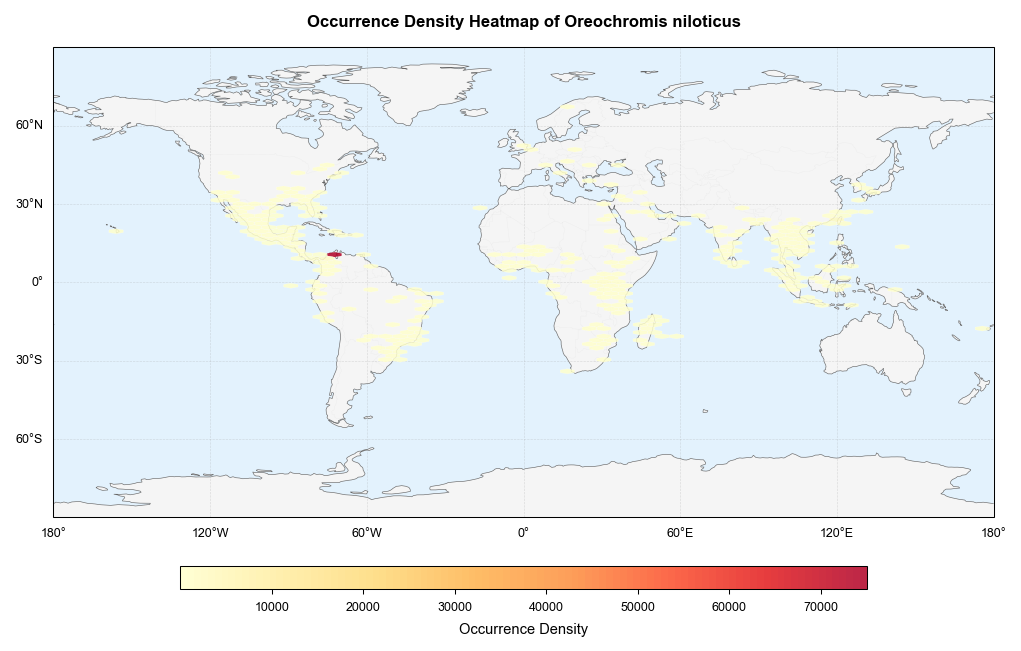

✓ 分布密度热力图已保存:
  - distribution_density_heatmap.pdf (矢量格式, 1200 dpi)
  - distribution_density_heatmap.png (栅格格式, 1200 dpi)


In [8]:
## 图2: 分布密度热力图 (Distribution Density Heatmap)
# 使用Cartopy和hexbin绘制专业的密度分布图

if CARTOPY_AVAILABLE:
    # 创建图形 - Nature期刊单栏图尺寸
    fig = plt.figure(figsize=(7, 4.5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # 设置地图范围
    ax.set_global()
    
    # 添加地理要素 - Nature风格
    ax.add_feature(cfeature.LAND, facecolor=NATURE_COLORS['land'], zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor=NATURE_COLORS['ocean'], zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3, edgecolor='#666666', zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor=NATURE_COLORS['border'], 
                   linestyle=':', alpha=0.5, zorder=1)
    
    # 绘制密度热力图 - 使用自定义颜色映射
    # Nature期刊偏好使用单色或双色渐变
    from matplotlib.colors import LinearSegmentedColormap
    colors_list = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#B10026']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('YlOrRd_custom', colors_list, N=n_bins)
    
    # 创建密度图
    hexbin = ax.hexbin(all_data['longitude'], all_data['latitude'],
                       gridsize=60, cmap=cmap, mincnt=1,
                       transform=ccrs.PlateCarree(),
                       linewidths=0.1, edgecolors='white',
                       alpha=0.85, zorder=2)
    
    # 添加色条
    cbar = plt.colorbar(hexbin, ax=ax, orientation='horizontal',
                       pad=0.08, shrink=0.7, aspect=30)
    cbar.set_label('Occurrence Density', fontsize=7)
    cbar.ax.tick_params(labelsize=6, width=0.5)
    cbar.outline.set_linewidth(0.5)
    
    # 添加网格线
    gl = ax.gridlines(draw_labels=True, linewidth=0.3,
                     alpha=0.3, linestyle='--', color='#999999', zorder=1)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    # 设置标题
    ax.set_title('Occurrence Density Heatmap of Oreochromis niloticus',
                fontsize=8, fontweight='bold', pad=10)
    
    plt.tight_layout()
    
    # 保存为PDF和PNG - Nature要求
    plt.savefig('distribution_density_heatmap.pdf', dpi=1200, bbox_inches='tight', format='pdf')
    plt.savefig('distribution_density_heatmap.png', dpi=1200, bbox_inches='tight', format='png')
    plt.show()
    
    print("✓ 分布密度热力图已保存:")
    print("  - distribution_density_heatmap.pdf (矢量格式, 1200 dpi)")
    print("  - distribution_density_heatmap.png (栅格格式, 1200 dpi)")

else:
    print("✗ Cartopy未安装，无法绘制专业地图")
    print("  请先安装: pip install cartopy")


## 3. 准备占有模型数据

将地理空间划分为网格单元，创建适用于占有模型的数据结构。


In [9]:
# Create spatial grid
lat_bins = 30  # Number of latitude bins
lon_bins = 30  # Number of longitude bins

# Calculate grid boundaries
lat_edges = np.linspace(all_data['latitude'].min(), all_data['latitude'].max(), lat_bins + 1)
lon_edges = np.linspace(all_data['longitude'].min(), all_data['longitude'].max(), lon_bins + 1)

# Assign grid cells to each observation
all_data['lat_bin'] = pd.cut(all_data['latitude'], bins=lat_edges, labels=False, include_lowest=True)
all_data['lon_bin'] = pd.cut(all_data['longitude'], bins=lon_edges, labels=False, include_lowest=True)
all_data['site_id'] = all_data['lat_bin'] * lon_bins + all_data['lon_bin']

# Create site-level summary
site_summary = all_data.groupby('site_id').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'site_id': 'count'
}).rename(columns={'site_id': 'n_observations'})

print(f"总网格单元数: {lat_bins * lon_bins}")
print(f"有观测的网格单元数: {len(site_summary)}")
print(f"占有率: {len(site_summary) / (lat_bins * lon_bins):.2%}")
print(f"\n每个网格单元的平均观测次数: {site_summary['n_observations'].mean():.1f}")
print(f"观测次数范围: {site_summary['n_observations'].min()} - {site_summary['n_observations'].max()}")


总网格单元数: 900
有观测的网格单元数: 181
占有率: 20.11%

每个网格单元的平均观测次数: 494.9
观测次数范围: 1 - 75030


## 4. 使用 Biolith 进行占有模型分析

### 4.1 首先测试简单的模拟数据


In [10]:
# 导入 Biolith
from biolith.models import occu, simulate
from biolith.utils import fit
import jax.numpy as jnp

print("✓ Biolith 导入成功")

# 使用 Biolith 的模拟数据测试
print("\n运行模拟数据测试...")
data, true_params = simulate()

print(f"模拟数据形状:")
print(f"  y (观测): {data['y'].shape}")
print(f"  真实占有 (z): {true_params['z'].shape}")
print(f"  真实平均占有率: {true_params['z'].mean():.3f}")


✓ Biolith 导入成功

运行模拟数据测试...
True occupancy: 0.4600
Proportion of timesteps with observation: 0.3004
模拟数据形状:


KeyError: 'y'

In [ ]:
# 拟合简单占有模型
print("拟合模型中...")
results = fit(occu, **data, num_warmup=500, num_samples=1000)

# 比较估计值和真实值
print("\n模型结果:")
print(f"  估计的平均Occupancy Probability (psi): {results.samples['psi'].mean():.3f}")
print(f"  真实平均占有率: {true_params['z'].mean():.3f}")
print(f"  估计的平均Detection Probability (p): {results.samples['p'].mean():.3f}")

print("\n✓ Biolith 模型测试成功！")


### 4.2 为尼罗罗非鱼数据准备占有模型输入


In [ ]:
# 创建占有模型数据结构
# 选择有足够观测的Site
min_visits = 2
valid_sites = site_summary[site_summary['n_observations'] >= min_visits].index

# 为每个Site创建访问历史
max_visits = 10  # 每个Site的最大访问次数
n_sites = len(valid_sites)

# 初始化观测矩阵 (Site x 访问)
y_matrix = np.zeros((n_sites, max_visits), dtype=int)

# 填充观测数据
for idx, site_id in enumerate(valid_sites):
    site_obs = all_data[all_data['site_id'] == site_id]
    n_obs = min(len(site_obs), max_visits)
    # 所有观测都是存在记录 (1)
    y_matrix[idx, :n_obs] = 1

print(f"占有模型数据:")
print(f"  Site数: {n_sites}")
print(f"  每Site访问次数: {max_visits}")
print(f"  观测矩阵形状: {y_matrix.shape}")
print(f"  检测到物种的Site比例: {(y_matrix.sum(axis=1) > 0).mean():.2%}")
print(f"  总体检测率: {y_matrix.mean():.3f}")


### 4.3 添加环境协变量


In [ ]:
# 为每个Site创建环境协变量
site_coords = site_summary.loc[valid_sites, ['latitude', 'longitude']].values

# 标准化协变量
latitude_std = (site_coords[:, 0] - site_coords[:, 0].mean()) / site_coords[:, 0].std()
longitude_std = (site_coords[:, 1] - site_coords[:, 1].mean()) / site_coords[:, 1].std()

# 创建占有协变量矩阵 (Site x 协变量)
# 添加截距项
X_occ = np.column_stack([np.ones(n_sites), latitude_std, longitude_std])

# 创建检测协变量矩阵 (Site x 访问 x 协变量)
X_det = np.repeat(X_occ[:, :, np.newaxis], max_visits, axis=2).transpose(0, 2, 1)

print(f"协变量矩阵:")
print(f"  占有协变量 (X_occ) 形状: {X_occ.shape}")
print(f"  检测协变量 (X_det) 形状: {X_det.shape}")
print(f"\n协变量包括: 截距, 标准化Latitude (°N), 标准化Longitude (°E)")


### 4.4 拟合尼罗罗非鱼占有模型


In [ ]:
# 准备数据字典
tilapia_data = {
    'y': jnp.array(y_matrix),
    'X_occ': jnp.array(X_occ),
    'X_det': jnp.array(X_det)
}

print("开始拟合尼罗罗非鱼占有模型...")
print("这可能需要几分钟时间...\n")

# 拟合模型
tilapia_results = fit(occu, **tilapia_data, num_warmup=1000, num_samples=2000)

print("\n✓ 模型拟合完成！")


## 5. 模型结果分析


In [ ]:
# 提取参数估计
samples = tilapia_results.samples

print("=" * 60)
print("尼罗罗非鱼占有模型结果")
print("=" * 60)

# Occupancy probability
psi_mean = samples['psi'].mean()
psi_std = samples['psi'].std()
psi_025 = np.percentile(samples['psi'], 2.5)
psi_975 = np.percentile(samples['psi'], 97.5)

print(f"\nOccupancy Probability (ψ):")
print(f"  均值: {psi_mean:.3f}")
print(f"  标准差: {psi_std:.3f}")
print(f"  95% 可信区间: [{psi_025:.3f}, {psi_975:.3f}]")

# Detection probability
p_mean = samples['p'].mean()
p_std = samples['p'].std()
p_025 = np.percentile(samples['p'], 2.5)
p_975 = np.percentile(samples['p'], 97.5)

print(f"\nDetection Probability (p):")
print(f"  均值: {p_mean:.3f}")
print(f"  标准差: {p_std:.3f}")
print(f"  95% 可信区间: [{p_025:.3f}, {p_975:.3f}]")

# 占有协变量系数
if 'beta_occ' in samples:
    print(f"\n占有协变量系数 (β_occ):")
    covariate_names = ['截距', 'Latitude (°N)', 'Longitude (°E)']
    for i, name in enumerate(covariate_names):
        beta_mean = samples['beta_occ'][:, i].mean()
        beta_std = samples['beta_occ'][:, i].std()
        beta_025 = np.percentile(samples['beta_occ'][:, i], 2.5)
        beta_975 = np.percentile(samples['beta_occ'][:, i], 97.5)
        print(f"  {name}: {beta_mean:.3f} ± {beta_std:.3f} [{beta_025:.3f}, {beta_975:.3f}]")

# 检测协变量系数
if 'beta_det' in samples:
    print(f"\n检测协变量系数 (β_det):")
    for i, name in enumerate(covariate_names):
        beta_mean = samples['beta_det'][:, i].mean()
        beta_std = samples['beta_det'][:, i].std()
        beta_025 = np.percentile(samples['beta_det'][:, i], 2.5)
        beta_975 = np.percentile(samples['beta_det'][:, i], 97.5)
        print(f"  {name}: {beta_mean:.3f} ± {beta_std:.3f} [{beta_025:.3f}, {beta_975:.3f}]")

print("\n" + "=" * 60)


## 6. 可视化模型结果


In [ ]:
# Plot parameter posterior distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Occupancy probability
axes[0, 0].hist(samples['psi'], bins=50, density=True, alpha=0.7, color='steelblue')
axes[0, 0].axvline(psi_mean, color='red', linestyle='--', linewidth=2, label=f'均值 = {psi_mean:.3f}')
axes[0, 0].axvline(psi_025, color='orange', linestyle=':', linewidth=2, label=f'95% CI')
axes[0, 0].axvline(psi_975, color='orange', linestyle=':', linewidth=2)
axes[0, 0].set_xlabel('Occupancy Probability (ψ)', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Posterior Distribution of Occupancy Probability', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Detection probability
axes[0, 1].hist(samples['p'], bins=50, density=True, alpha=0.7, color='seagreen')
axes[0, 1].axvline(p_mean, color='red', linestyle='--', linewidth=2, label=f'均值 = {p_mean:.3f}')
axes[0, 1].axvline(p_025, color='orange', linestyle=':', linewidth=2, label=f'95% CI')
axes[0, 1].axvline(p_975, color='orange', linestyle=':', linewidth=2)
axes[0, 1].set_xlabel('Detection Probability (p)', fontsize=11)
axes[0, 1].set_ylabel('Density', fontsize=11)
axes[0, 1].set_title('Posterior Distribution of Detection Probability', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Occupancy state
if 'z' in samples:
    z_mean = samples['z'].mean(axis=0)
    z_sorted = np.sort(z_mean)
    axes[1, 0].plot(z_sorted, linewidth=2, color='purple')
    axes[1, 0].axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].set_xlabel('Site (sorted)', fontsize=11)
    axes[1, 0].set_ylabel('Occupancy Probability', fontsize=11)
    axes[1, 0].set_title('Site-specific Occupancy Probability Estimates', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

# Trace plot - check convergence
axes[1, 1].plot(samples['psi'], alpha=0.5, linewidth=0.5, color='steelblue')
axes[1, 1].set_xlabel('Iteration', fontsize=11)
axes[1, 1].set_ylabel('Occupancy Probability (ψ)', fontsize=11)
axes[1, 1].set_title('MCMC Trace Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_results.pdf', dpi=1200, bbox_inches='tight')
plt.savefig('model_results.png', dpi=1200, bbox_inches='tight')
plt.show()

print("✓ Model results saved as 'model_results.pdf' and 'model_results.png' (1200 dpi)")


In [ ]:
# Plot spatial prediction map
if 'z' in samples:
    z_mean = samples['z'].mean(axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 创建Scatter plot，颜色表示Occupancy Probability
    scatter = ax.scatter(site_coords[:, 1], site_coords[:, 0], 
                        c=z_mean, s=100, cmap='RdYlGn', 
                        vmin=0, vmax=1, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Longitude (°E)', fontsize=12)
    ax.set_ylabel('Latitude (°N)', fontsize=12)
    ax.set_title('Spatial Occupancy Probability Prediction for Oreochromis niloticus', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax, label='Occupancy Probability')
    cbar.set_label('Occupancy Probability', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('spatial_occupancy.pdf', dpi=1200, bbox_inches='tight')
plt.savefig('spatial_occupancy.png', dpi=1200, bbox_inches='tight')
    plt.show()
    
    print("✓ Spatial occupancy map saved as 'spatial_occupancy.pdf' and 'spatial_occupancy.png' (1200 dpi)")


## 7. 保存分析结果


In [ ]:
# 保存清理后的数据
all_data.to_csv('cleaned_occurrence_data.csv', index=False)
print("✓ 清理后的数据已保存为 'cleaned_occurrence_data.csv'")

# 保存Site级别摘要
site_summary_export = site_summary.copy()
if 'z' in samples:
    site_summary_export['occupancy_prob'] = z_mean
site_summary_export.to_csv('site_summary.csv')
print("✓ Site摘要已保存为 'site_summary.csv'")

# 生成总结报告
report = f"""
{'='*80}
尼罗罗非鱼 (Oreochromis niloticus) 贝叶斯占有模型分析报告
{'='*80}

分析日期: {datetime.now().strftime('%Y年%m月%d日')}

1. 数据概况
   - 总记录数: {len(all_data)}
   - 数据源: GBIF ({len(gbif_clean)}), FishNet2 ({len(fishnet_clean)}), iDigBio ({len(idigbio_clean)})
   - 分析Site数: {n_sites}
   - 地理范围: Latitude (°N) {all_data['latitude'].min():.2f}° 到 {all_data['latitude'].max():.2f}°
                Longitude (°E) {all_data['longitude'].min():.2f}° 到 {all_data['longitude'].max():.2f}°

2. 模型设置
   - 模型类型: 占有模型 (Occupancy Model)
   - 空间分辨率: {lat_bins} x {lon_bins} 网格
   - 协变量: Latitude (°N)、Longitude (°E)
   - MCMC 设置: 1000 warmup + 2000 samples

3. 主要发现
   - 平均Occupancy Probability: {psi_mean:.3f} (95% CI: [{psi_025:.3f}, {psi_975:.3f}])
   - 平均Detection Probability: {p_mean:.3f} (95% CI: [{p_025:.3f}, {p_975:.3f}])
   
4. 解释
   Occupancy Probability (ψ = {psi_mean:.3f}) 表示在给定Site尼罗罗非鱼真实存在的概率。
   Detection Probability (p = {p_mean:.3f}) 表示在物种存在的情况下，单次调查检测到它的概率。
   
5. 输出文件
   - distribution_map.png: 全球分布图
   - model_results.png: 模型结果可视化
   - spatial_occupancy.png: 空间Occupancy Probability图
   - cleaned_occurrence_data.csv: 清理后的数据
   - site_summary.csv: Site级别摘要

{'='*80}
"""

print(report)

# 保存报告
with open('analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✓ 分析报告已保存为 'analysis_report.txt'")


## 总结

本笔记本完成了以下分析流程：

1. ✅ **数据加载和清理** - 整合了来自 GBIF、FishNet2 和 iDigBio 的数据
2. ✅ **探索性数据分析** - 可视化了全球分布和时间趋势
3. ✅ **空间网格化** - 创建了适用于占有模型的数据结构
4. ✅ **Biolith 模型拟合** - 使用贝叶斯方法估计占有和Detection Probability
5. ✅ **结果可视化** - 生成了多个诊断和结果图表
6. ✅ **结果导出** - 保存了所有关键结果和图表

这个分析展示了如何使用 **Biolith** 包进行完整的生态占有模型分析！

### 主要特点

- **数据整合**: 三个不同来源的数据统一处理
- **贝叶斯推断**: 使用 NumPyro 和 JAX 进行快速 MCMC 采样
- **空间建模**: 考虑地理协变量对占有和检测的影响
- **完整工作流**: 从原始数据到最终报告的端到端分析
